In [1]:
#imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from PathFinder import find_path

In [2]:
#read data
PATH = find_path()

#select files
#files = ['application_train.csv','application_test.csv',]
files = ['preprocessed_train.csv', 'preprocessed_test.csv']
"""         
          'bureau.csv', 
         'bureau_balance.csv', 'credit_card_balance.csv',
         'installments_payments.csv', 'POS_CASH_balance.csv',
         'previous_application.csv']
"""
data_files=[]
data=[]
print("files used: {}".format(files))

#actually read files
for file in files:
    stuff = pd.read_csv(PATH+file,header=0,engine='python')
    #print(stuff)
    data_files.append(file)
    data.append(stuff)

files used: ['preprocessed_train.csv', 'preprocessed_test.csv']


In [3]:
#select and convert columns
original_train = data[0] #save the original because we'll need some stuff later
original_test = data[1]
app_train = data[0].copy()
app_test = data[1].copy()

#delete ID cols
del app_train['SK_ID_CURR']
del app_test['SK_ID_CURR']

app_train_y = app_train['TARGET']
new_cols_x = app_train.columns.values.tolist()
new_cols_x.remove('TARGET')
app_train_x = app_train[new_cols_x]

print('Training Features shape: ', app_train_x.shape) #235 cols
print('Testing Features shape: ', app_test.shape) #235 cols

Training Features shape:  (307511, 235)
Testing Features shape:  (48744, 235)


In [12]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
X_train_lda = lda.fit_transform(app_train_x, app_train_y)
X_test_lda = lda.transform(app_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [19]:
#new dataframe for plotting
#app_train_y.shape
#X_train_lda.shape
#X_train_lda[:,0]
df = pd.DataFrame({'TARGET': app_train_y, 'LDA_c1': X_train_lda[:,0]})
df.head()

,TARGET,LDA_c1
0,1,3.533468
1,0,-0.735740
2,0,-0.528407
3,0,-0.062890
4,0,0.170828


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


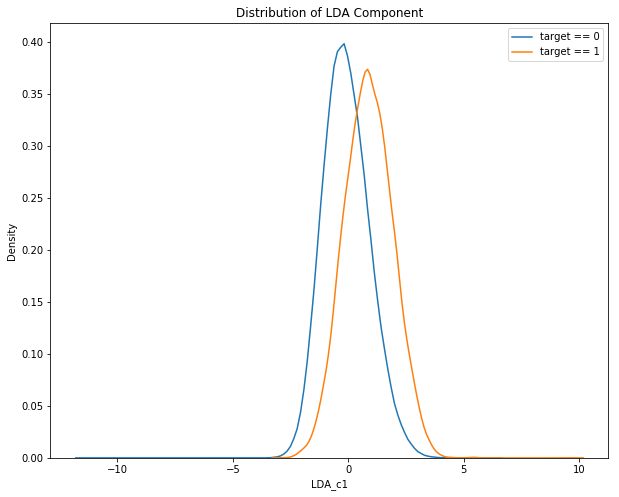

In [20]:
#plot LDA/Target correlation
#with variables this similar, why does LDA perform well?
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 0, 'LDA_c1'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 1, 'LDA_c1'], label = 'target == 1')

# Labeling of plot
plt.xlabel('LDA_c1'); plt.ylabel('Density'); plt.title('Distribution of LDA Component');

In [5]:
#apply logistic regression
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001, random_state=20)

# Train on the training data
#log_reg.fit(app_train_x, app_train_y)
log_reg.fit(X_train_lda, app_train_y)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=20,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [6]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(X_test_lda)[:, 1]

In [7]:
# Submission dataframe
submit = original_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.126283
1,100005,0.255218
2,100013,0.124430
3,100028,0.096460
4,100038,0.183531


In [8]:
# Save the submission to a csv file
overwrite = True
if overwrite:
    submit.to_csv('results/log_reg_lda_0.csv', index = False)

Submitted to kaggle  
log_reg_lda_0.csv created with LDA(n_components=1)  
score: 0.73560  
  
log_reg_lda_1.csv created with LDA(n_components=2) #goes to 1 anyways because num classes  
score: 0.73560

In [9]:
print(log_reg.coef_.shape)

(1, 1)


In [10]:
print('intercept:', log_reg.intercept_[:,None][0][0])
print('weights:',log_reg.coef_[0])
#np.hstack((log_reg.intercept_[:,None], log_reg.coef_))
#print('weights:')
#for feature, weight in zip(new_cols_x, log_reg.coef_[0]):
#    #print('{:3.7} {}'.format(weight, feature))
#    print(f'{weight} {feature}')

intercept: -1.8717932565640865
weights: [0.42874752]
